Initial state  [[0 0]
 [0 1]]


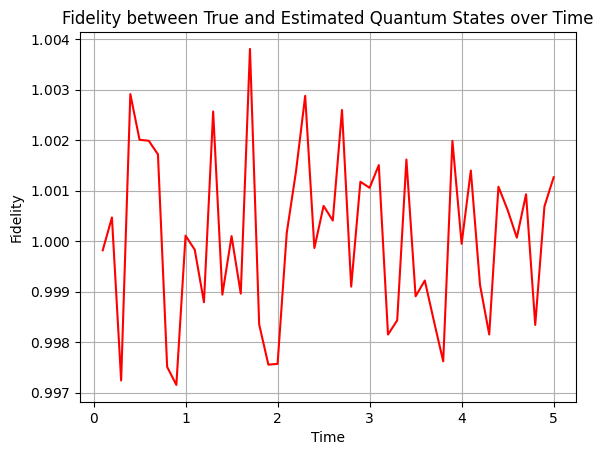

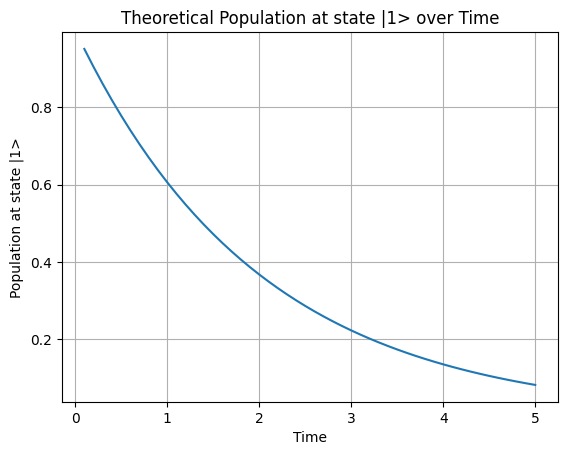

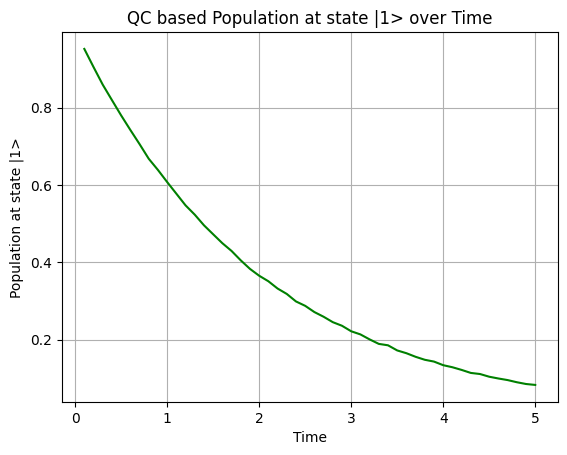

In [ ]:
# Define Kraus Operators
import numpy as np
from qutip import *
from qiskit.circuit.library import UnitaryGate
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from scipy.linalg import svd , sqrtm
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from numpy.linalg import eig
from qutip import Qobj




gamma = 0.5           
sm = destroy(2)                   # σ-
sp = sm.dag()                     # σ+
H = Qobj([[0, 0], [0, 0]]) 
c_ops = [np.sqrt(gamma) * sm]
L1 = liouvillian(H, c_ops)
####################################################3
def super_to_choi(q_oper: Qobj) -> (Qobj, int, int):
# Extract raw array and dims
    data = q_oper.full()
    dims = q_oper.dims  
    d0 = dims[0][0][0] 
    d1 = dims[1][0][0] 
    # Build the Choi array 
    choi_arr = (
        data.reshape((d0, d1, d0, d1))
            .transpose(3, 1, 2, 0)
            .reshape((d0*d1, d0*d1))
    )

    choi = Qobj(choi_arr,
                dims=[[ [d1], [d0] ],   # row dims = [d_out, d_in]
                      [ [d1], [d0] ]],  # col dims = same for a square 4×4 matrix
                superrep='choi')
    return choi, d0, d1


def choi_to_kraus(choi: Qobj, d0: int, d1: int, tol: float = 1e-9) -> list[Qobj]:
    # Eigen decomposition of the Choi matrix
    vals, vecs = eig(choi.full())
    kraus_ops = []
    for val, vec in zip(vals, vecs.T):
        if val > tol:
            mat = vec.reshape((d1, d0), order='F')
           
            K = Qobj(np.sqrt(val) * mat,
                     dims=[[d1], [d0]])
            kraus_ops.append(K)
    return kraus_ops


def super_to_kraus(q_oper: Qobj, tol: float = 1e-9) -> list[Qobj]:

    choi, d0, d1 = super_to_choi(q_oper)
    return choi_to_kraus(choi, d0, d1, tol)


#############################################




##############################################
#SVD and walsh  
def SVD(Kraus_op):
    
    U_1, sigma_1, V_dagger = svd(Kraus_op)
    
    sigma_vals1 = sigma_1
    sigma1 = np.diag(sigma_1)
    f_k1 = np.zeros(4)
    for i, sigma_val in enumerate(sigma_vals1):
        val = float(np.clip(sigma_val, -1, 1))
        f_k1[i] = np.arccos(val)
        f_k1[i+2] = -np.arccos(val)
    # print(f_k1)
    W1 = np.array([[1, 1, 1, 1],
              [1, -1, 1, -1], 
              [1, 1, -1, -1],
              [1, -1, -1, 1]])
    a1 = (W1 @ f_k1) / 4
    U_sigma = np.diag(np.exp(1j * np.array(f_k1)))
    # L = (U_1 @ sigma1 @ V_dagger)
    return U_1 , U_sigma , V_dagger

#############################################################


def Quantum_circuit(U, sigma,V):
    qc = QuantumCircuit(2)
    qc.x(0)

    V = UnitaryGate(V, label="Vgate")
    qc.append(V, [0])

    qc.h(1)

    U_sigma_gate = UnitaryGate(sigma, label="Usigma")
    qc.append(U_sigma_gate, [0, 1])

 
    U = UnitaryGate(U, label="Ugate")
    qc.append(U, [0])
    qc.h(1)
    qc.measure_all()
    # qc.save_statevector()
    num_shots = 100000
    sim = AerSimulator(method='statevector')
    tc = transpile(qc, sim)
    result = sim.run(tc, shots= num_shots, memory=True).result()
    
    # statevector = result.get_statevector(qc)
    counts = result.get_counts(qc) 
    # mem = result.get_memory(qc)
    # print("Sampler counts:", counts)
    counts_list = [
        counts.get('00', 0)/num_shots,
        counts.get('01', 0)/num_shots
    ]
    sqrt_counts = np.sqrt(counts_list)
    return np.array(ket2dm(Qobj(sqrt_counts)).full())
    
# Uncomment only to see the statevetor and the noiseless simulation
    # final_state =[]
    # for i in range(2):
    #     final_state.append(statevector[i])

    # final_state = np.array(final_state)
    # rho0_t = np.outer(final_state, np.conj(final_state))
    # # print("State vector:\n", np.round(rho0_t,8))
    # qc.draw('mpl')
    # return rho0_t
    
##############################################################

def kraus_ops_(t):
    gamma = 0.5
    lambda_t = 1 - np.exp((-gamma*t))
    K0 = np.array([[1, 0], [0, np.sqrt(1 - lambda_t)]])
    K1 = np.array([[0, np.sqrt(lambda_t)], [0, 0]])
    return K0, K1
############################################################


def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner_term = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    return (np.real(np.trace(inner_term)))**2

fidelity_ = []
population_t = []
population_Qc = []
time = np.linspace(0.1, 5, 50) # Time from 0 to 5 with 100 points

############################################################
rho = np. array([[0,0],[0,1]]) # state rho(0) = |1> <1|
print(f"Initial state ", rho)

for t in time:
   k0 , k1 = kraus_ops_(t)
   rho_t = (k0 @ rho @ k0.conj().T ) + (k1 @ rho @ k1.conj().T)
   superprop = (t * L1).expm()
   kraus_ops = super_to_kraus(superprop)
   kraus_op_ = [np.array(k.full()) for k in kraus_ops]
   K0 = kraus_ops[0]
   K1 = kraus_ops[1]
   K0= np.real(K0.full())
   K1 = np.real(K1.full())
   U1 , sigma1 , V1 = SVD(K1)
   U2 , sigma2 , V2 = SVD(K0)
   rho_0T = Quantum_circuit(U1,sigma1, V1)
   rho_1T = Quantum_circuit(U2,sigma2, V2)
   rho_f =  rho_0T + rho_1T
   population_t.append(np.trace(rho_t @ rho))
   population_Qc.append(np.trace( rho_f @ rho))
   fidelity_value = fidelity(rho_t,rho_f)
   fidelity_.append(fidelity_value)
############################################




plt.plot(time, fidelity_, c='red')
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity between True and Estimated Quantum States over Time")
plt.grid(True)
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=False)
ax.yaxis.get_offset_text().set_visible(False)
plt.show()
plt.plot(time, population_t)
plt.xlabel("Time")
plt.ylabel("Population at state |1>")
plt.title("Theoretical Population at state |1> over Time")
plt.grid(True)
plt.show()
plt.plot(time, np.real(population_Qc),c='green')
plt.xlabel("Time")
plt.ylabel("Population at state |1>")
plt.title("QC based Population at state |1> over Time")
plt.grid(True)
plt.show()
